In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd



import numpy as np
import matplotlib.pyplot as plt


from glob import glob

import os, sys

sys.path.append('/Users/silas/Documents/switchdrive/')
import helper_scripts as hs

from io import StringIO


import seaborn as sns
from helper_scripts import DimensionalReduction,MetaTable
from helper_scripts import effect_plot as EP




In [2]:
working_dir='../WD/'

In [3]:
metadata= pd.read_table(f'../metadata.tsv',index_col=0)

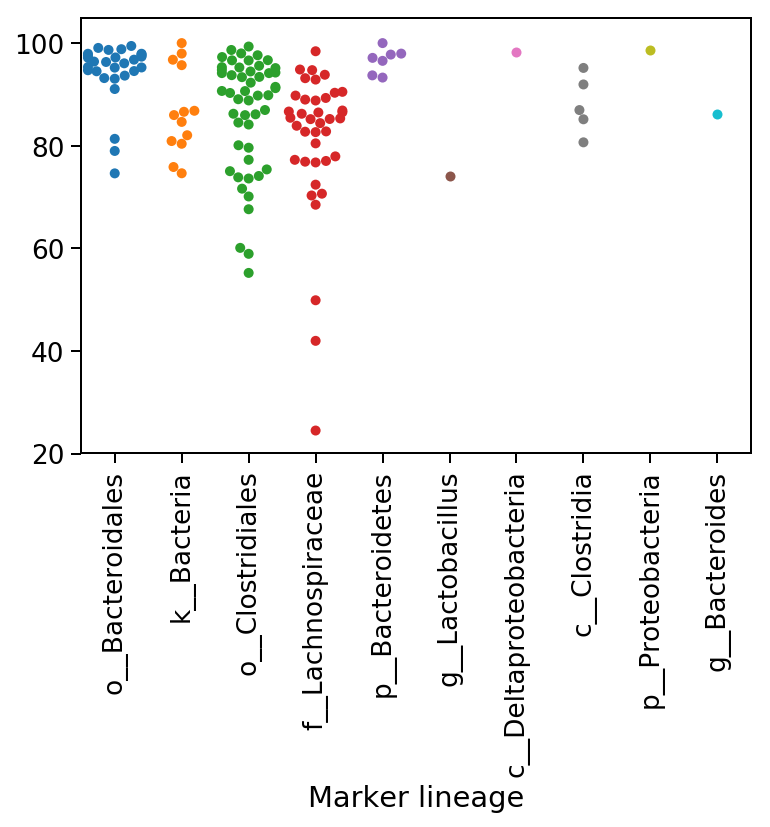

In [4]:
GenomeInfo= pd.concat((pd.read_table(f'{working_dir}/genomes/checkm/completeness.tsv',index_col=0),
                     pd.read_table(f'{working_dir}/genomes/checkm/taxonomy.tsv',index_col=0)),1).dropna(how='all',axis=1)



checkmTax = pd.DataFrame(list(GenomeInfo['Taxonomy (contained)'].apply(lambda s: s.split(';'))),
                       index=GenomeInfo.index)
checkmTax.columns=['Kindom','Phylum','Class','Order','Family','Genus']


ax=sns.swarmplot(y=GenomeInfo.Completeness-5*GenomeInfo.Contamination,x=GenomeInfo['Marker lineage'].map(lambda s: s.split()[0]))
_ =ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [5]:
Labels= checkmTax.fillna(method='ffill',axis=1).Genus+' '+checkmTax.index

In [6]:
DT= pd.read_table(f'{working_dir}/genomes/taxonomy/taxonomy_names.tsv')
DT= DT.drop_duplicates(['# bin']).sort_values('# bin')

DT.index= DT['# bin']

Tax= DT.loc[:,'superkingdom':].fillna('not classified')
Tax= Tax.applymap(lambda s: s.split(':')[0])
Tax= Tax.replace('not classified',np.nan)
Tax=Tax.fillna(method='ffill',axis=1)

Labels=Tax.species+' '+Tax.index

In [7]:
INTERPRO_HEADERS=[
 'Protein Accession',
 'Sequence MD5',
 'Sequence Length',
 'Analysis',
 'Signature Accession',
 'Signature Description',
 'Start location',
 'Stop location',
 'Score',
 'Status',
 'Date',
 'InterPro accession',
 'InterPro description']

In [8]:

inter_pro_dir=f'{working_dir}/genomes/annotations/interproscan/'
N_anotated_genes= 0
I= []

Description=[]

for file in glob(inter_pro_dir+'*.tsv'):

    name= os.path.splitext(os.path.basename(file))[0]
    
    store = StringIO("\t".join(INTERPRO_HEADERS)+'\n'+open(file).read())

    d = pd.read_table(store,index_col=0)
    
    N_anotated_genes+=len(d.index.unique())
    
    # pfam
    d = d.loc[(d['Analysis']=='Pfam')|(d['Analysis']=='TIGRFAM')]
    
    
    
    Description.append(pd.Series(index= d['Signature Accession'].values, data=  d['Signature Description'].values))

    acc= d.groupby('Signature Accession').size()
    
    I.append(pd.Series(acc , name=name))
I=pd.concat(I,axis=1,sort=True).fillna(0).T
Description=pd.concat(Description)
Description= Description.loc[~Description.index.duplicated()]

In [9]:
Description= Description + ' '+ Description.index

In [10]:
orf2gene= pd.read_table('../WD/genomes/annotations/GeneClusters50/orf2gene.tsv',index_col=0,squeeze=True)
N_anotated_genes/orf2gene.shape[0]

0.7474356720004689

# Genomeprop

In [11]:
Pathways = pd.read_csv(f'{working_dir}/genomes/annotations/GenomeProperties.tsv',sep='\t',index_col=0).T
Pathways=Pathways.replace({'YES':1.,'NO':0,'PARTIAL':0.5})

In [12]:
from pygenprop.database_file_parser import parse_genome_property_file
genprop_tree = parse_genome_property_file(open('/Users/silas/Documents/GitHub/genome-properties/flatfiles/genomeProperties.txt'))

Description= pd.Series(index=Pathways.columns)
for gp in Description.index:
    Description.loc[gp]=genprop_tree[gp].name

Leave_Ids= [gp.id for gp in genprop_tree.leafs]

In [13]:
I = Pathways#[Leave_Ids]

# Gene cluster

In [8]:
Clusters= pd.read_table('../WD/genomes/annotations/GeneClusters50/orf2gene.tsv',sep='\t',index_col=0)
Clusters['Genome']=Clusters.index.map(lambda s: s.split('_')[0])


EggNOG= pd.read_table('../WD/genomes/annotations/GeneClusters50/eggNog.tsv',index_col=0)

bactNOG= EggNOG['Matching_OGs'].str.contains('bactNOG')
bactNOG= EggNOG.loc[bactNOG,'Matching_OGs'].apply(lambda s: [nog for nog in s.split(',') if 'bactNOG' in nog][0])

bactNOG.name='bactNOG'

In [9]:
Clusters= Clusters.join(bactNOG,on='Gene')

#I=Clusters.groupby(['Gene','Genome']).size().unstack().T.fillna(0)
I=Clusters.groupby(['bactNOG','Genome']).size().unstack().T.fillna(0)

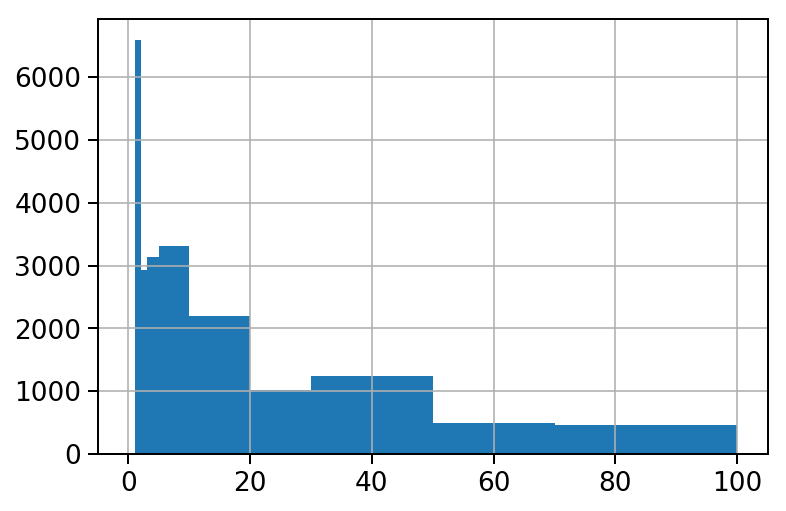

In [10]:
I.sum().hist(bins=[0,1,2,3,5,10,20,30,50,70,100])

In [26]:
Description= EggNOG.eggNOG_HMM_model_annotation

# Prokka

In [153]:
Prokka= pd.read_table('../WD/genomes/annotations/prokka.tsv',sep='\t')
Prokka['Genome']=Prokka.locus_tag.dropna().map(lambda s: s.split('_')[0])

In [154]:

functional_cat='COG'

I=Prokka.groupby([functional_cat,'Genome']).size().unstack().T.fillna(0)

In [155]:
index= Prokka[functional_cat].drop_duplicates().dropna()
Description= pd.Series(index=index.values, data=Prokka.loc[index.index,'product'].values)

## PCA on genes

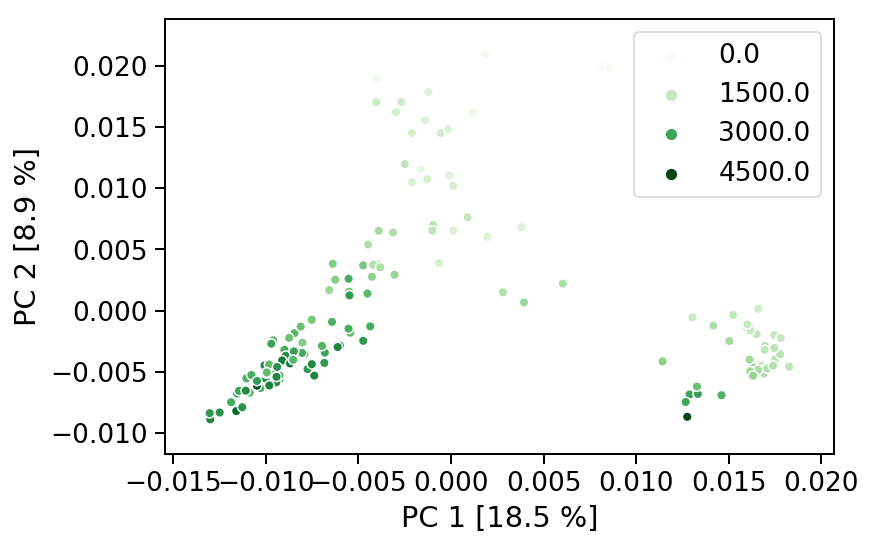

In [13]:


DR =DimensionalReduction.DimensionalReduction((I.T/I.sum(1)).T) #((I.T-I.mean(1))/I.std(1)).T)

pl=DR.plot_Components_2D(hue = I.sum(1),palette='Greens')


plt.show()

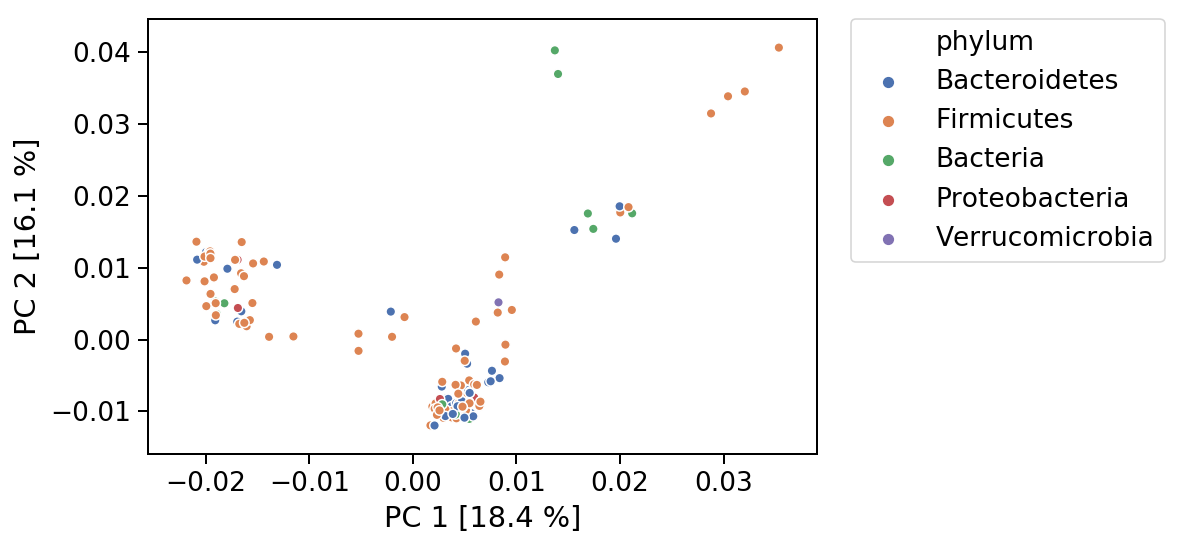

In [15]:

DR.plot_Components_2D(hue=Tax.phylum,palette='deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

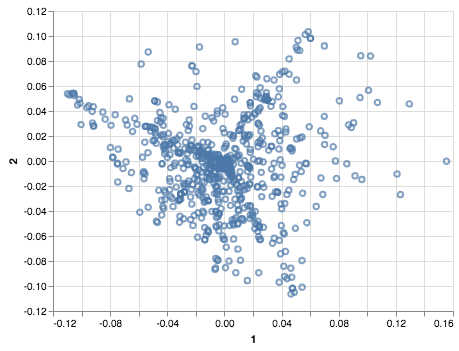

In [16]:

DimensionalReduction.altair_plot2D(DR.components.T)

In [17]:
Description.loc['GenProp1397']

'(Kdo)2-lipid A biosynthesis I'

# aggregate genes

In [14]:
presence_absence= (I>0)*1.
presence_absence= presence_absence.loc[:,presence_absence.std()>0]


## Relab

In [15]:
#D = pd.read_table(f'../bins/{bin_folder}/counts/normalized_counts.tsv',index_col=0)
D = pd.read_table(f'{working_dir}/genomes/counts/median_coverage_genomes.tsv',index_col=0)


D = (D.T/D.sum(1)).T
D.head()

,MAG001,MAG002,MAG003,MAG004,MAG005,MAG006,MAG007,MAG008,MAG009,MAG010,...,MAG138,MAG139,MAG140,MAG141,MAG142,MAG143,MAG144,MAG145,MAG146,MAG147
shHC1,0.046398,0.013608,0.000000,0.001478,0.012896,0.001948,0.000134,0.007039,0.000000,0.000000,...,0.005810,0.008100,0.000148,0.003519,0.004930,0.007845,0.0,0.005615,0.004245,0.000000
shHC2,0.033744,0.011312,0.000000,0.000177,0.001376,0.005233,0.000341,0.000000,0.000313,0.000000,...,0.002099,0.013369,0.000000,0.002562,0.000000,0.006378,0.0,0.004347,0.007400,0.000273
shHC3,0.059028,0.015640,0.000000,0.000324,0.008006,0.000324,0.000000,0.000000,0.000000,0.000648,...,0.014943,0.011702,0.003436,0.003209,0.002318,0.004019,0.0,0.004198,0.001264,0.000000
shHC4,0.022808,0.016684,0.000000,0.001223,0.003641,0.001594,0.000000,0.000000,0.000000,0.000000,...,0.003507,0.010774,0.000148,0.000000,0.000000,0.017470,0.0,0.007356,0.007741,0.000000
shHC5,0.046114,0.013777,0.000371,0.000742,0.008381,0.000742,0.001669,0.000000,0.000000,0.000000,...,0.007788,0.006508,0.000408,0.003764,0.001854,0.001038,0.0,0.006508,0.000723,0.000371


/Users/silas/Documents/switchdrive/helper_scripts/Significance.py:181: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  Results= pd.Panel.fromDict(Results)
/Users/silas/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1147: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  allow_dups=True)
/Users/silas/anaconda3/lib/python3.6/site-packa

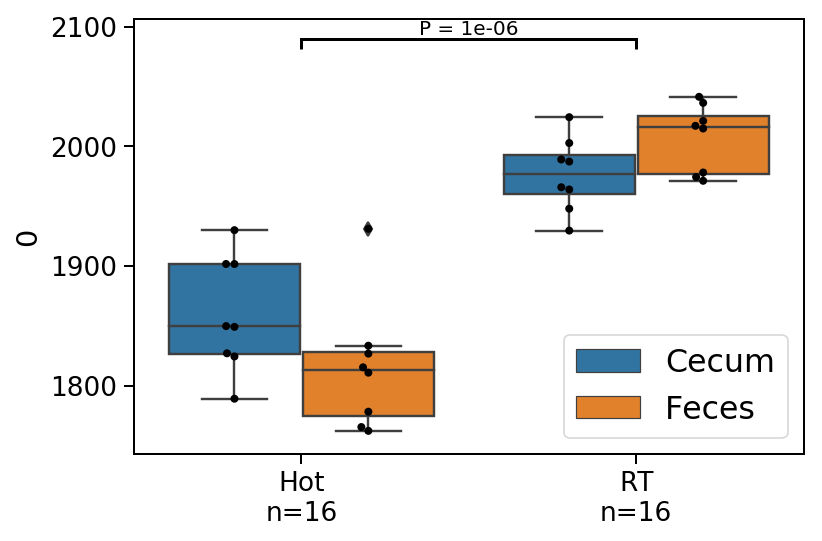

In [16]:



Genes= D.loc[:,presence_absence.index]@presence_absence

Genes= Genes.astype(float)


hs.Viewpoint(Genes.sum(1),
             grouping_variable=metadata.Group, grouping_variable2=metadata.Source).Boxplot(0)


# Rawcounts clr

Genes.PF03279/Genes.PF02606

# PCA

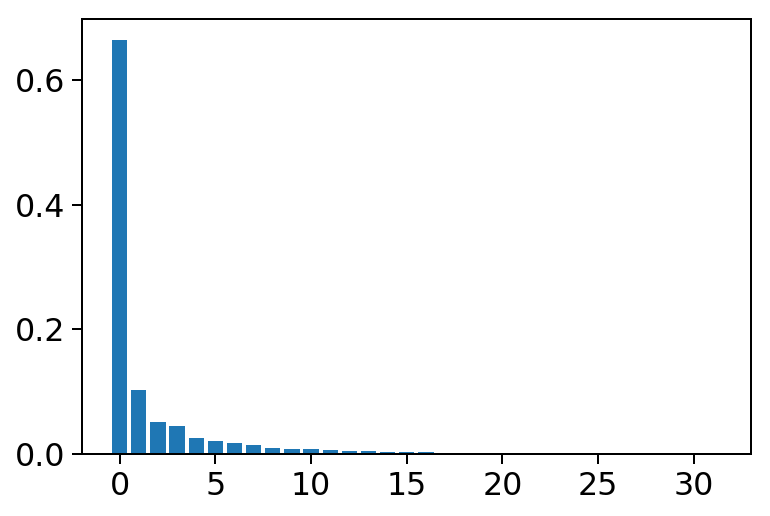

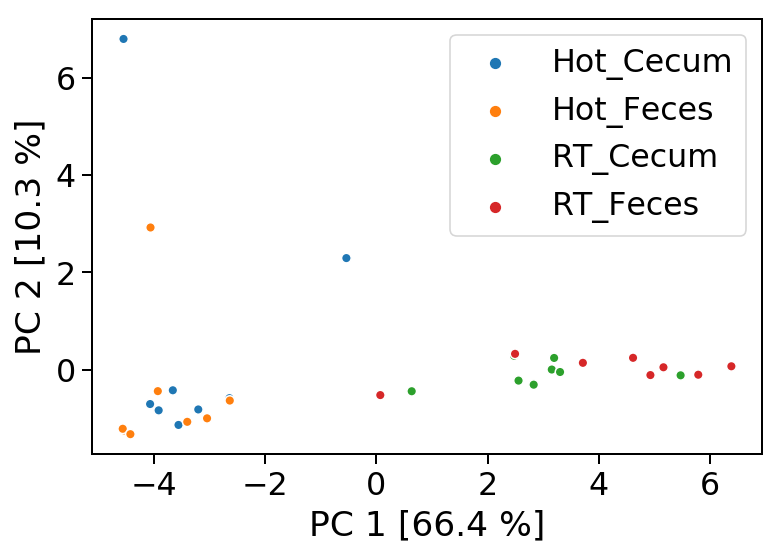

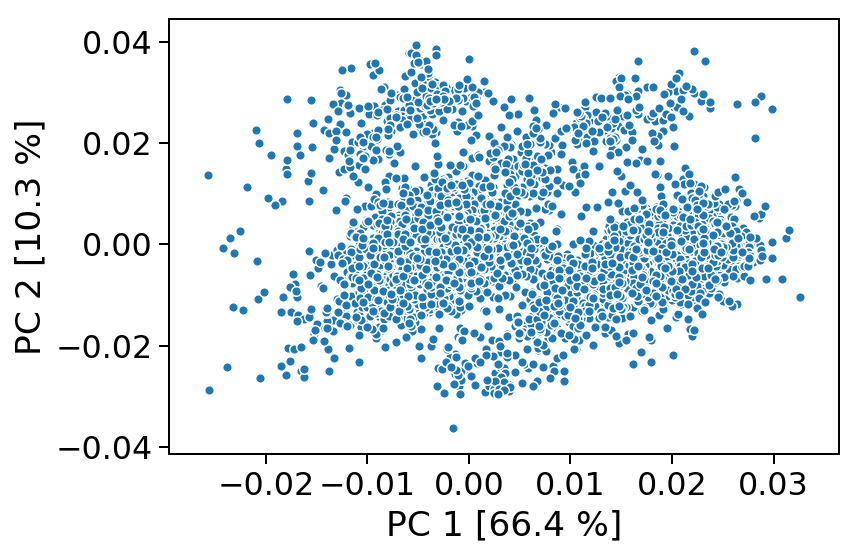

In [17]:
DR= DimensionalReduction.DimensionalReduction(Genes)

plt.bar(np.arange(DR.decomposition.explained_variance_ratio_.shape[0]),
        DR.decomposition.explained_variance_ratio_)
plt.show()
DR.plot_Components_2D (
                hue=metadata.Group+'_'+metadata.Source)
plt.show()
DR.plot_Loadings_2D()

In [22]:
sig= DR.components.columns[DR.components.loc[1].abs()>0.1]

Description.loc[sig]

Genome_Property_ID
GenProp0853     Lantibiotic system, gallidermin/epidermin family
GenProp0967       Radical SAM maturase system, CXXX repeats type
GenProp1756    Poly(3-O-beta-D-glucopyranosyl-N-acetylgalacto...
GenProp1111                       Acetyl-CoA carboxylase complex
GenProp1371                     Uracil degradation I (reductive)
GenProp0714    Galactarate utilization via tartronate semi-al...
GenProp1242                              Muropeptide degradation
GenProp1273                                  Thymine degradation
GenProp1225                          D-galactarate degradation I
GenProp1598                      Superoxide radicals degradation
GenProp0944           Cohesin/dockerin (cellulosome-like) system
dtype: object

# metatable

In [22]:
order=['RT','Hot']
table_params=dict(sample_data=metadata,
             test_variable='Group',
            grouping_variables='Source',
            order_test=order, order_grouping=['Cecum','Feces'],
            colors= ['grey',sns.color_palette('deep')[3]])




In [23]:
M= MetaTable.Viewpoint(Genes,feature_data=Description, **table_params)
M.calculate_stats(comparisons=[order])

KeyError: "None of [Index(['05BZ1@bactNOG', '05BZ2@bactNOG', '05BZ3@bactNOG', '05BZ4@bactNOG',\n       '05BZ5@bactNOG', '05BZ6@bactNOG', '05BZ7@bactNOG', '05BZ8@bactNOG',\n       '05BZA@bactNOG', '05BZB@bactNOG',\n       ...\n       '090WY@bactNOG', '090XC@bactNOG', '090XH@bactNOG', '090XP@bactNOG',\n       '090XY@bactNOG', '090YF@bactNOG', '090YJ@bactNOG', '090YM@bactNOG',\n       '090YN@bactNOG', '090YX@bactNOG'],\n      dtype='object', name='bactNOG', length=22123)] are in the [index]"

In [25]:



Stats = M.stats.copy()
Stats.columns= Stats.columns.droplevel(-1)

S=Stats['pBH']
FC=Stats['median_diff']



Medians= M.data.groupby([M.test_variable,M.grouping_variables]).median().T


if all(M.data>=0):#when not clr
    
    Medianslog= Medians.replace(0,0.00001).apply(np.log2)
    FC= Medianslog['Hot']-Medianslog['RT']

In [26]:
sig= (S<0.05).any(1) &(FC.abs()>1).all(1)  &(FC.prod(1)>0)
sig= FC.loc[sig,'Feces'].sort_values(ascending=False).index
len(sig)

29

In [28]:
Source='Feces'




#sig= (S[Source]<0.05) &(FC[Source].abs()>1)

medians= M.data.loc[M.samples['Source']==Source].groupby(M.samples.Group).median().T
Ab=medians.max(1)


sig= (S[Source]<0.01)& (Ab>0.2)& (FC[Source].abs()>0.4)
sig= (S[Source]<0.01)&(FC[Source].abs()>1)&(Stats['median_diff'][Source]>0.05)

sig= Stats['median_diff'].loc[sig,Source].sort_values(ascending=False).index
len(sig)

12

In [94]:
sig=['TIGR01273','TIGR01230','PF02675','TIGR00417','PF02675','TIGR03330','PF01536','TIGR00417']+\
['PF01593','PF00583']

In [51]:
sig="GenProp" + pd.Series(['1571', '0219','0641','1272','1610']+['1433',"0642",
"0643",
"0644",
"1733"])



sig= Stats['median_diff'].loc[sig,Source].sort_values(ascending=False).index

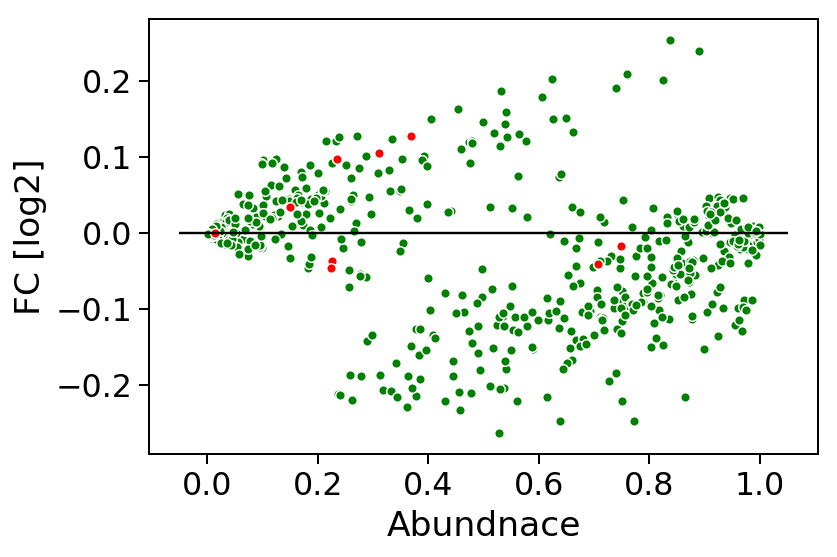

In [52]:
Effect=Stats['median_diff'][Source]
medians= M.data.loc[M.samples['Source']==Source].groupby(M.samples.Group).median().T
Ab=medians.max(1)


from adjustText import adjust_text

def MA_plot(abundance,change,sig=None,ax=None):
    
    if ax is None:
        ax = plt.subplot(111)
        
    abundance= pd.Series(abundance)
    change= pd.Series(change)

    sns.scatterplot(abundance,change,
                    color='g',ax=ax)
    if sig is not None:
        sns.scatterplot(abundance.loc[sig],change.loc[sig],color='r',ax=ax)
    
    ax.set_xlabel('Abundnace')
    ax.set_ylabel('FC [log2]')
    ax.hlines(0,*ax.get_xlim())
    
    #ax.fill_between(ax.get_xlim(),-1,1,alpha=0.5,color='grey')

#f, axe = plt.subplots(1,2,figsize=(15,5),sharey=True)
    
#MA_plot(Stats['median_diff'][Source],Effect,sig)
MA_plot(Ab,Effect,sig)


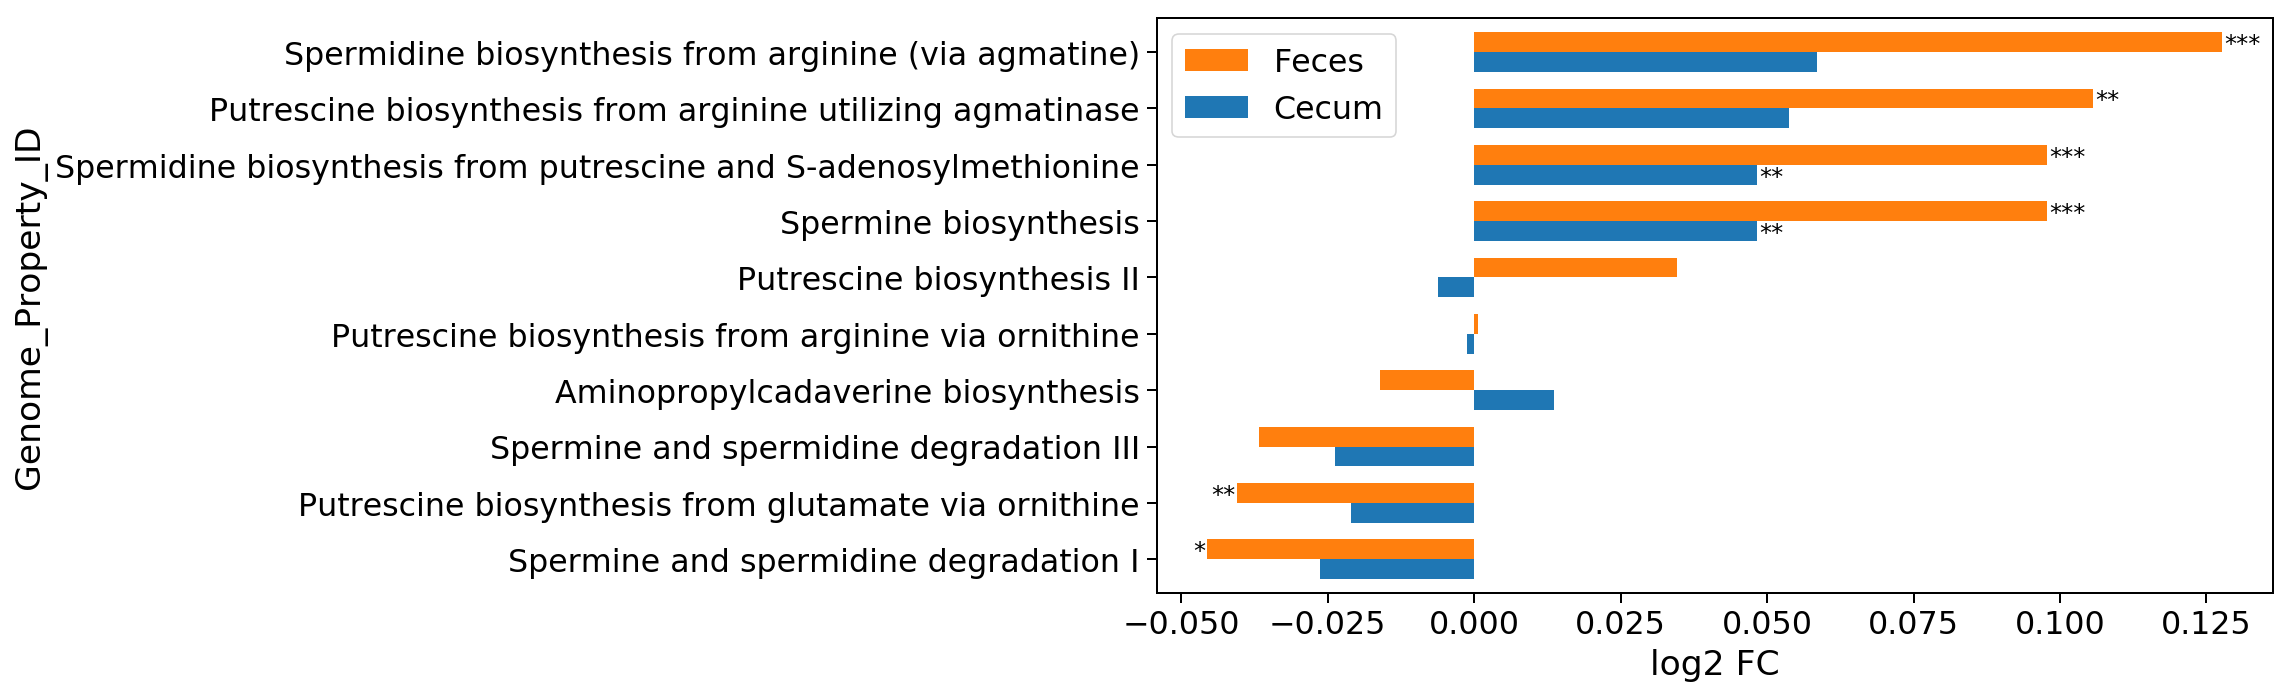

In [53]:
EP.effect_plot(Stats['median_diff'].loc[sig], Stats.loc[sig,'pBH'],Labels=Description)
_= plt.xlabel('log2 FC')

#hs.plotting.saveplot('Effectplot',figurefolder='Figures')

In [36]:
goi = 'GenProp0911'#"TIGR00417"

GenProp0911 Butyryl-CoA to butyrate, acetate CoA-transferase pathway


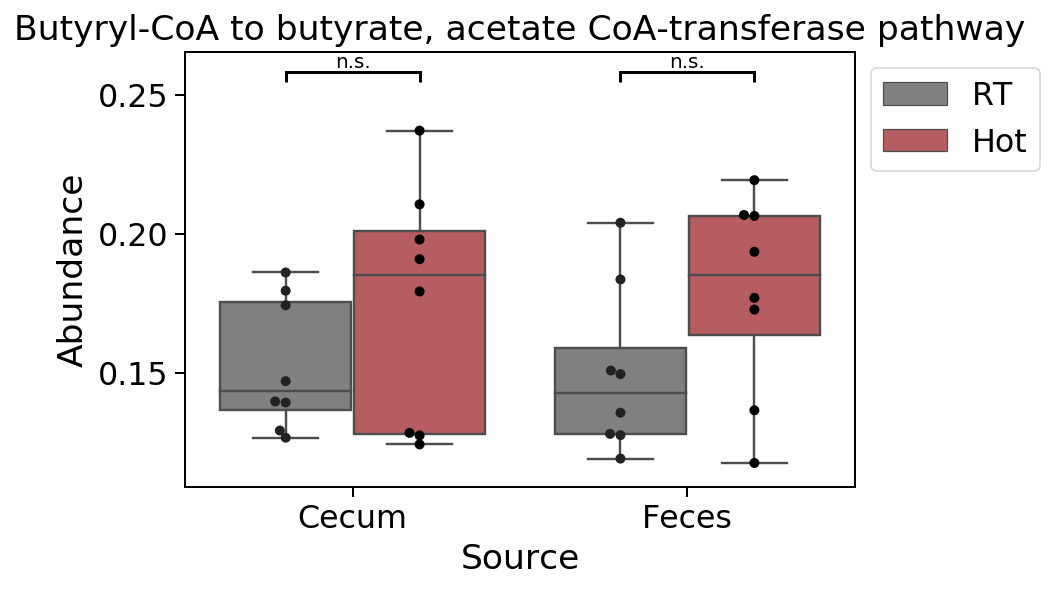

In [37]:
#goi= sig[0] #'GenProp1337'
print(goi,Description[goi])


M.boxplot(goi,distance_between_sig_labels=0)
ax= plt.gca()
ax.set_title(ax.get_ylabel())
_=ax.set_ylabel('Abundance')

In [64]:




out= presence_absence[sig].copy()
out= out.rename(columns=Description+ '; '+Description.index).join(Tax)
out.to_csv('Figures/Amines.tsv',sep='\t')

In [65]:
! open Figures

In [41]:
MAGs_with_pathway=presence_absence.query(f'{goi}==1').index

In [42]:
Tax.loc[MAGs_with_pathway]

,superkingdom,phylum,class,order,family,genus,species
MAG004,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria
MAG010,Bacteria,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes
MAG024,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,Clostridium
MAG025,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,Bacteria,bacterium 1xD42-87
MAG026,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Lachnospiraceae,Lachnospiraceae bacterium A4
MAG033,Bacteria,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes,Firmicutes
MAG035,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium,Clostridium sp. CAG
MAG044,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Rikenellaceae,Alistipes,Alistipes
MAG048,Bacteria,Firmicutes,Clostridia,Clostridiales,Ruminococcaceae,Anaerotruncus,Anaerotruncus
MAG068,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiales,Clostridiales,Clostridiales


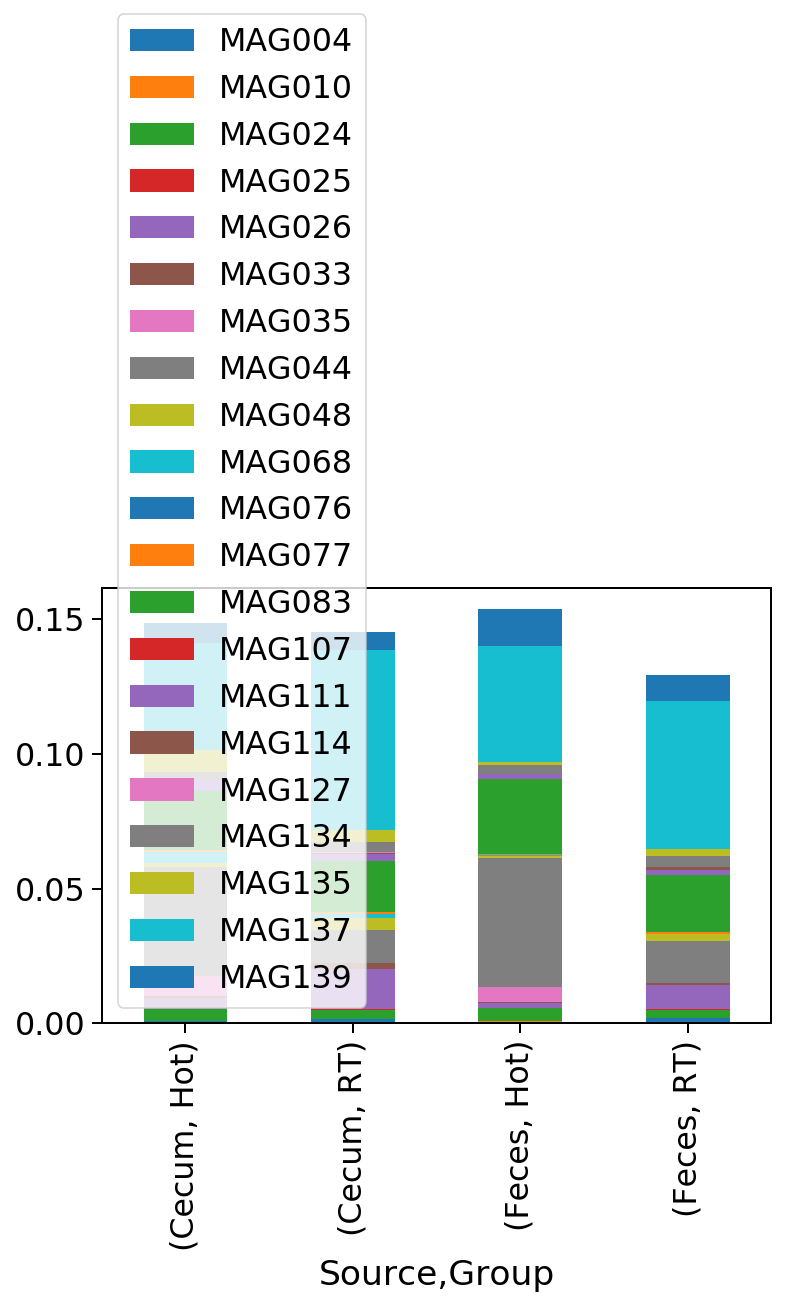

In [47]:
D[MAGs_with_pathway].groupby([metadata.Source,metadata.Group]).median().plot.bar(stacked=True)

In [50]:
checkmTax.loc['MAG044']

Kindom         k__Bacteria
Phylum    p__Bacteroidetes
Class       c__Bacteroidia
Order     o__Bacteroidales
Family    f__Rikenellaceae
Genus         g__Alistipes
Name: MAG044, dtype: object

# Score

In [86]:
Description.loc[Effect.head().index]

COG
COG1662                         IS1 family transposase IS1Sa
COG1067                                       Lon protease 2
COG1648                            Precorrin-2 dehydrogenase
COG2203                             Diguanylate cyclase DgcP
COG4167    Putrescine export system ATP-binding protein SapF
dtype: object

In [328]:
genprop_tree['GenProp1695'].description

'This property has been automatically generated from MetaCyc and has not been manually verified to check the validity of the InterPro signatures used for the evidence. See MetaCyc for additional information and references relating to this property.'

In [163]:
data=Genes.copy()

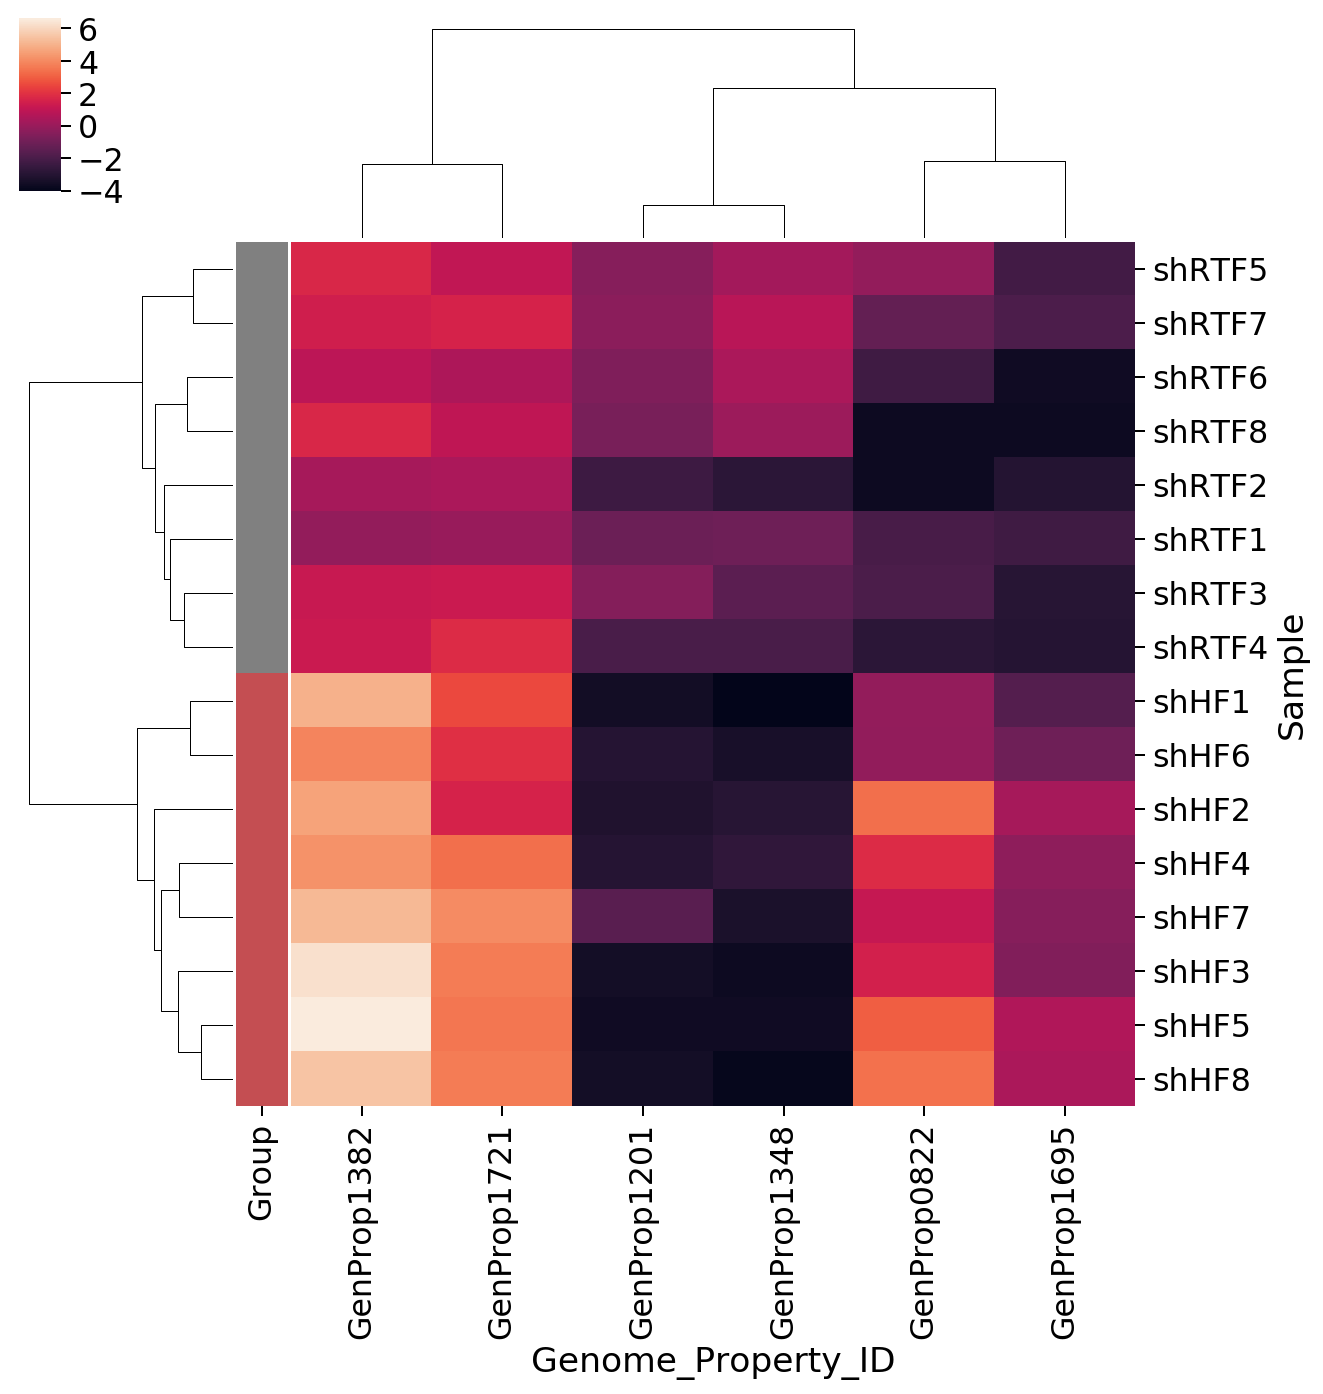

In [115]:
colors=M.test_variable.map(dict(zip(M.order_test,M.colors)) )
sns.clustermap(Genes.loc[metadata.Source==Source,sig],row_colors=colors)

In [178]:
Description.name='Description'

In [183]:

I_synth=['PF01762','PF02485','PF02709','PF13733','PF02709','PF13733','PF02709','PF13733']
LLactaldehyde=['PF01070','TIGR02632']

FC.loc[LLactaldehyde].sort_values((Source,'CR')).join(Description)

/Users/silas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """
/Users/silas/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(Cecum, CR)","(Cecum, CE)","(Feces, CR)","(Feces, CE)",Description
PF01070,-0.069326,4.852261,1.308957,1.819183,FMN-dependent dehydrogenase
TIGR02632,NaN,NaN,NaN,NaN,NaN


In [179]:
FC.loc[sig.intersection(same_dir)].sort_values((Source,'CR')).join(Description)

/Users/silas/anaconda3/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(Cecum, CR)","(Cecum, CE)","(Feces, CR)","(Feces, CE)",Description
PF10639,-10.163488,-54.255728,1.333252,-35.535671,Putative transmembrane family 234
PF15899,-10.163488,-54.255728,1.333252,-35.535671,BNR-Asp box repeat
TIGR00702,-10.163488,-54.255728,1.333252,-35.535671,TIGR00702: YcaO-type kinase domain
TIGR00013,-3.004855,-55.132821,0.719972,-35.949228,taut: 4-oxalocrotonate tautomerase family enzyme
PF15892,-2.750617,-20.692526,1.161401,-2.504645,BNR repeat-containing family member
TIGR02276,-2.640341,-53.597429,-1.775838,-34.748754,beta_rpt_yvtn: 40-residue YVTN family beta-pro...
PF06101,-2.640341,-53.597429,-1.775838,-34.748754,Vacuolar protein sorting-associated protein 62
PF03350,-2.640341,-53.597429,-1.775838,-34.748754,"Uncharacterized protein family, UPF0114"
PF07821,-2.486782,-14.100734,-1.362443,-3.999134,Alpha-amylase C-terminal beta-sheet domain
PF13497,-2.460418,-14.271779,0.122723,-4.004859,Domain of unknown function (DUF4121)


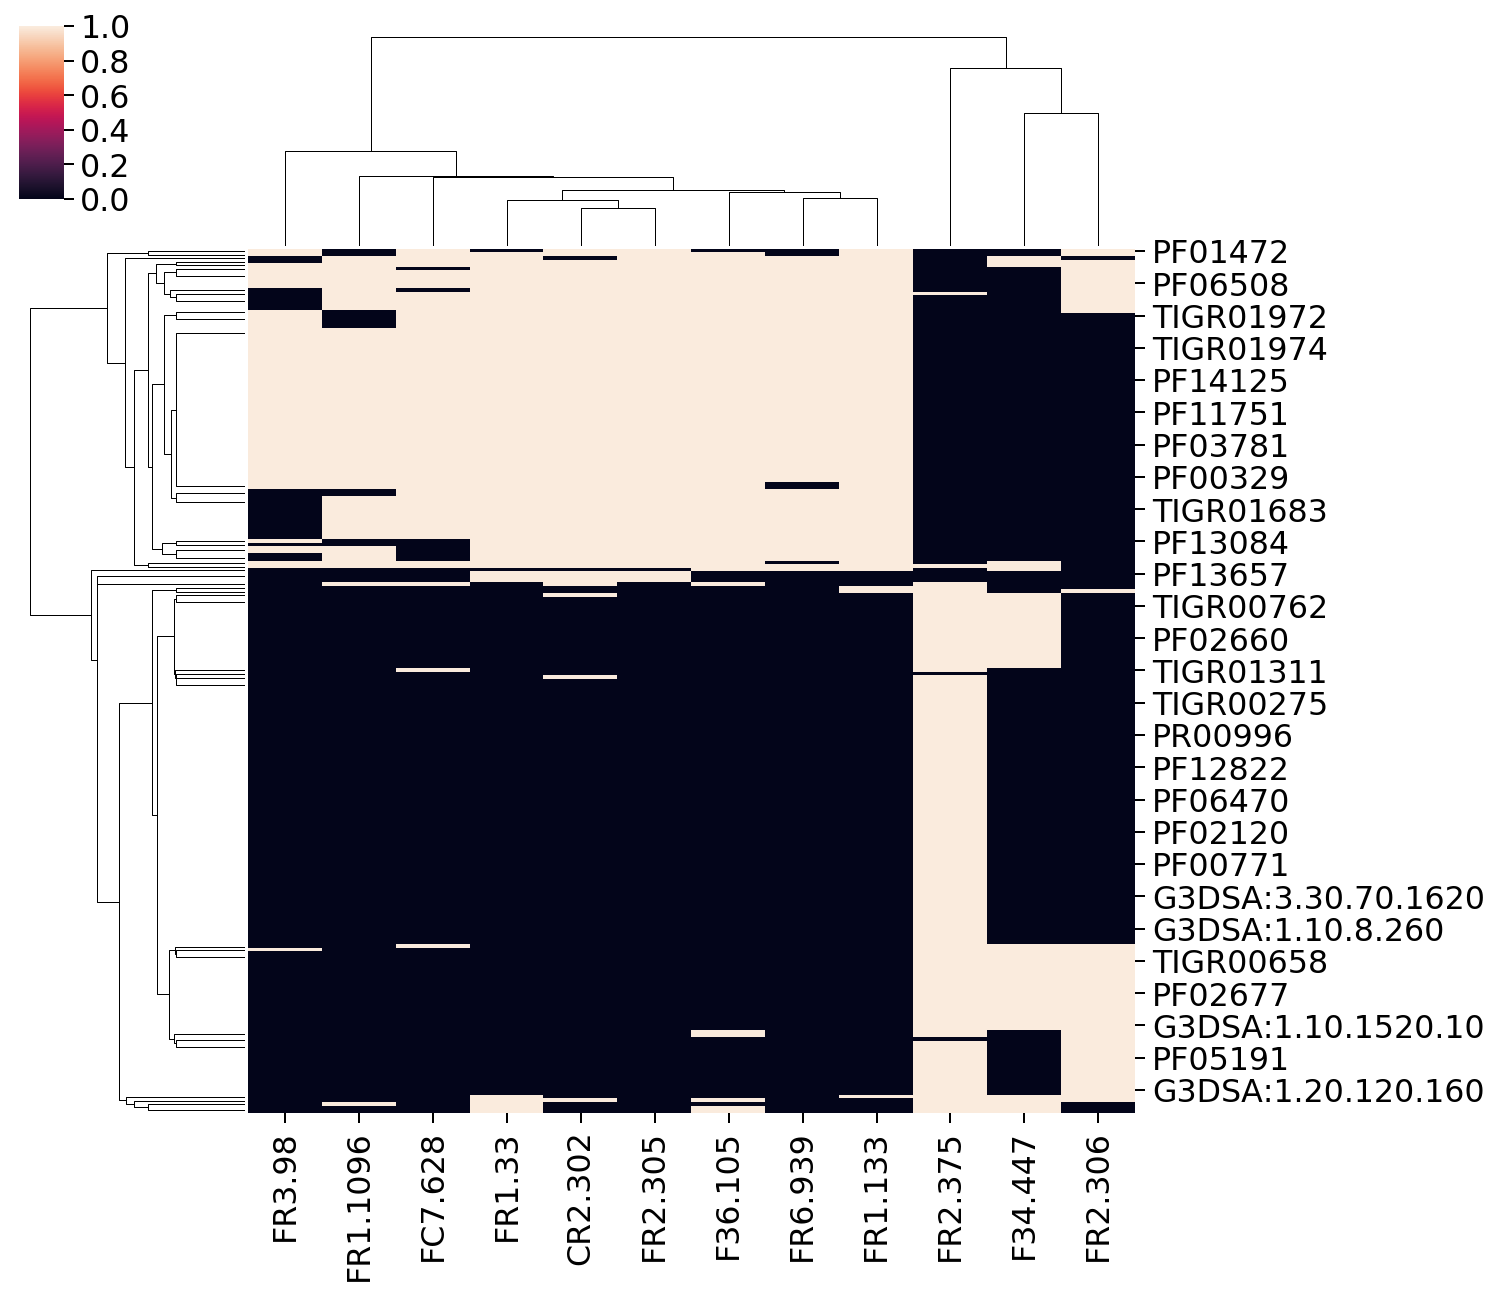

In [385]:
sns.clustermap(I.loc[sig_cecum,sig].T)